# Overview

This notebook implements Vision Transformer (ViT) model by Alexey Dosovitskiy et al for image classification, and demonstrates it on the Cassava Leaf Disease Classification dataset.

# Model Architecture

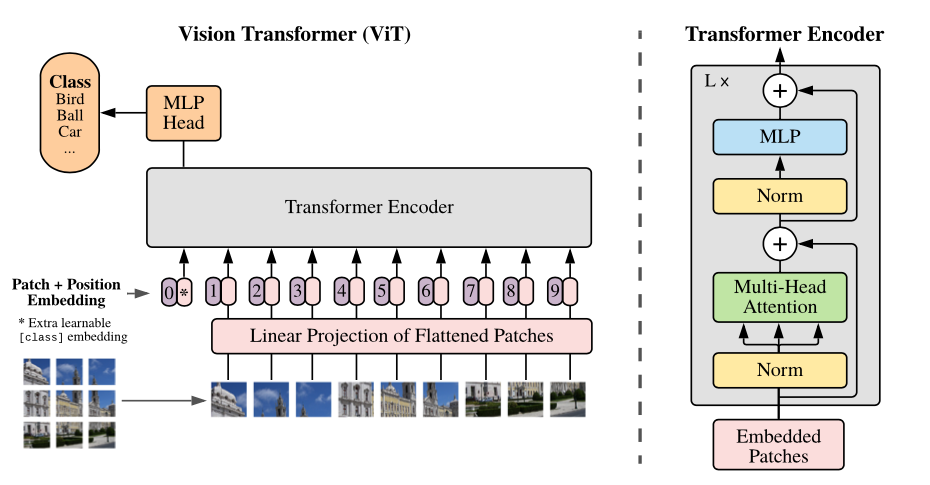

# Libraries and Configurations

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

TensorFlow Version 2.4.1


In [2]:
image_size = 224
batch_size = 16
n_classes = 5

train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'
test_path = '/kaggle/input/cassava-leaf-disease-classification/test_images'

df_train = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv', dtype = 'str')

test_images = glob.glob(test_path + '/*.jpg')
df_test = pd.DataFrame(test_images, columns = ['image_path'])

classes = {0 : "Cassava Bacterial Blight (CBB)",
           1 : "Cassava Brown Streak Disease (CBSD)",
           2 : "Cassava Green Mottle (CGM)",
           3 : "Cassava Mosaic Disease (CMD)",
           4 : "Healthy"}

# Data Augmentations

In [3]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

# Data Generator

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

test_gen = datagen.flow_from_dataframe(dataframe = df_test,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = batch_size,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (image_size, image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
Found 1 validated image filenames.


### Sample Images Visualization

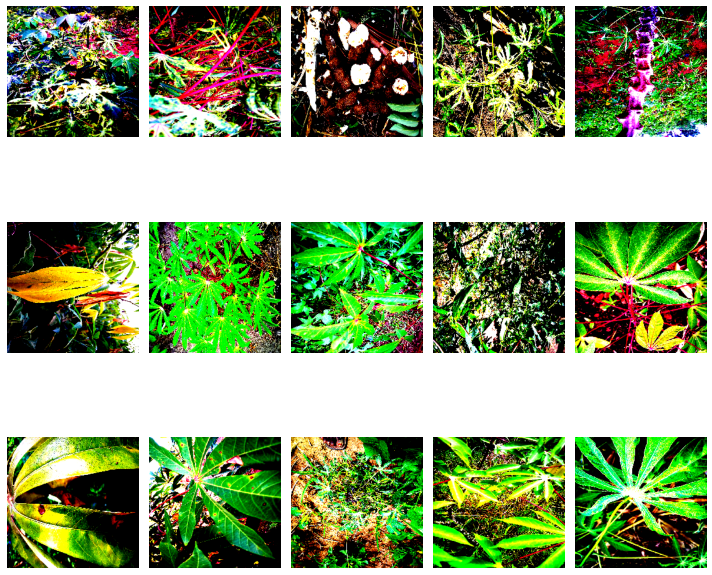

In [5]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Hyperparameters

In [6]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1

patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

# Building the Model and it's Components

## 1. Multilayer Perceptron (MLP)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

## 2. Patch Creation Layer

In [8]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Sample Image Patches Visualization

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


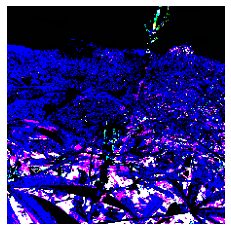

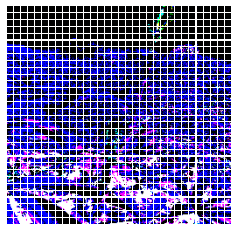

In [9]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

## 3. Patch Encoding Layer
The `PatchEncoder` layer will linearly transform a patch by projecting it into a vector of size `projection_dim`. In addition, it adds a learnable position embedding to the projected vector.

In [10]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the `MultiHeadAttention` layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a `[batch_size, num_patches, projection_dim]` tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with `Flatten()` and used as the image representation input to the classifier head. Note that the `GlobalAveragePooling1D` layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [11]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [12]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, lr_scheduler, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)

1069/1069 [==============================] - 703s 650ms/step - loss: 6.3605 - accuracy: 0.1909 - val_loss: 2.5071 - val_accuracy: 0.1016

Epoch 00001: val_accuracy improved from -inf to 0.10159, saving model to ./model.hdf5


# Model Results

In [14]:
print('Training results')
model.evaluate(train_gen)

print('Validation results')
model.evaluate(valid_gen)

Training results
1070/1070 [==============================] - 297s 277ms/step - loss: 2.5566 - accuracy: 0.1019
Validation results
268/268 [==============================] - 75s 279ms/step - loss: 2.5314 - accuracy: 0.1014


[2.5313754081726074, 0.10142556577920914]

# Summary

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset. <br>

**References:** <br>
Keras Docs: https://keras.io/api/ <br>
Research Paper: https://arxiv.org/pdf/2010.11929.pdf